## Phân tích Khách hàng Sâu
#### **Mục tiêu (Objectives)**

- Phân tích hành vi mua sắm của khách hàng
- Xây dựng customer segmentation (Phân khúc khách hàng)
- Thực hiện RFM Analysis (Phân tích RFM)
- Phát hiện customer lifetime value patterns (Mẫu giá trị trọn đời khách hàng)

## 1. Import và setup

In [71]:
# Import các thư viện cần thiết
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)      # Hiển thị tất cả cột
pd.set_option('display.width', None)            # Không giới hạn chiều rộng
pd.set_option('display.max_colwidth', None)     # Không giới hạn độ rộng cột

# Load biến môi trường từ file .env
load_dotenv()

# Lấy thông tin kết nối database
DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_GOLD = os.getenv("DB_GOLD")

# Tạo kết nối tới Gold database
gold_engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_GOLD}")


## 2. Load data 

In [72]:
# Load du lieu tat ca cac bang

df_orders = pd.read_sql_table("fact_orders", gold_engine)
df_orders_items = pd.read_sql_table("fact_order_items", gold_engine)
df_products = pd.read_sql_table("dim_products", gold_engine)
df_customers = pd.read_sql_table("dim_customers", gold_engine)
df_date = pd.read_sql_table("dim_date", gold_engine)
df_pages = pd.read_sql_table("dim_order_pages", gold_engine)
df_payments = pd.read_sql_table("dim_order_payments", gold_engine)
df_shipping = pd.read_sql_table("dim_order_shipping", gold_engine)
df_warehouses = pd.read_sql_table("dim_order_warehouses", gold_engine)
df_shop = pd.read_sql_table("dim_shop", gold_engine) 

## Nội dung phân tích (Analysis Content)

### A. RFM Analysis (Recency, Frequency, Monetary)
RFM là phương pháp phân tích khách hàng dựa trên 3 yếu tố:
- R (Recency): Thời gian gần đây nhất khách hàng mua hàng
- F (Frequency): Tần suất mua hàng của khách hàng
- M (Monetary): Giá trị tiền tệ khách hàng đã chi tiêu

In [73]:
# Tính toán RFM cho từng khách hàng
df_orders['date_id'] = df_orders['date_id'].astype(int)
def calculate_rfm_metrics():
    
    # Lấy dữ liệu cần thiết
    rfm_data = df_orders.merge(df_customers, on='customer_id', how='inner')
    rfm_data = rfm_data.merge(df_date, left_on='date_id', right_on='date_id', how='inner')
    
    # Tính toán RFM
    rfm_table = rfm_data.groupby('customer_id').agg({
        'full_date': 'max',                    # Recency: Ngày mua cuối cùng
        'order_id': 'count',                   # Frequency: Số lần mua
        'total_price': 'sum'                   # Monetary: Tổng giá trị mua
    }).reset_index()
    
    # Đổi tên cột
    rfm_table.columns = ['customer_id', 'last_order_date', 'frequency', 'monetary']
    
    # Tính Recency (số ngày từ lần mua cuối)
    current_date = rfm_table['last_order_date'].max()
    rfm_table['recency'] = (current_date - rfm_table['last_order_date']).dt.days
    
    # Thêm thông tin khách hàng
    rfm_table = rfm_table.merge(
        df_customers[['customer_id', 'name', 'gender', 'phone']], 
        on='customer_id', 
        how='left'
    )
    
    print(f"Hoàn thành! Phân tích {len(rfm_table)} khách hàng")
    return rfm_table

# Chạy tính toán RFM
rfm_table = calculate_rfm_metrics()
print(f"\nRFM Table Shape: {rfm_table.shape}")

Hoàn thành! Phân tích 36080 khách hàng

RFM Table Shape: (36080, 8)


In [74]:
# Hệ thống chấm điểm RFM (1-5 scale)
def calculate_rfm_scores(rfm_table):
    
    # Recency Score (càng gần đây càng cao điểm)
    def recency_score(days):
        if days <= 30:      return 5  # Rất gần đây
        elif days <= 90:    return 4  # Gần đây  
        elif days <= 180:   return 3  # Trung bình
        elif days <= 365:   return 2  # Xa
        else:               return 1  # Rất xa
    
    # Frequency Score (càng nhiều lần càng cao điểm)
    def frequency_score(count):
        if count >= 10:     return 5  # Rất thường xuyên
        elif count >= 5:    return 4  # Thường xuyên
        elif count >= 3:    return 3  # Trung bình
        elif count >= 2:    return 2  # Ít
        else:               return 1  # Rất ít
    
    # Monetary Score (càng chi nhiều càng cao điểm)
    def monetary_score(amount):
        if amount >= 1000000:    return 5  # VIP
        elif amount >= 500000:  return 4  # Cao
        elif amount >= 300000:  return 3  # Trung bình
        elif amount >= 100000:   return 2  # Thấp
        else:                    return 1  # Rất thấp
    
    # Áp dụng scoring
    rfm_table['recency_score'] = rfm_table['recency'].apply(recency_score)
    rfm_table['frequency_score'] = rfm_table['frequency'].apply(frequency_score)
    rfm_table['monetary_score'] = rfm_table['monetary'].apply(monetary_score)
    
    # Tạo RFM segment
    rfm_table['rfm_segment'] = (
        rfm_table['recency_score'].astype(str) + 
        rfm_table['frequency_score'].astype(str) + 
        rfm_table['monetary_score'].astype(str)
    )
    return rfm_table

# Tính RFM scores
rfm_table = calculate_rfm_scores(rfm_table)
rfm_table.head(2)


,customer_id,last_order_date,frequency,monetary,recency,name,gender,phone,recency_score,frequency_score,monetary_score,rfm_segment
0,000030f6-43c2-41ec-b84c-940bff8016f3,2024-11-26,1,649000.0,263,Son Anh,Nam,0886569099,2,1,4,214
1,0000db9e-55c4-462c-bbdc-bd16659fa47f,2024-04-29,1,538000.0,474,Đinh Nghị,Nữ,0367324375,1,1,4,114


### B. Customer Segmentation

In [75]:
def create_customer_segments(rfm_table):
    def assign_segment(row):
        r, f, m = row['recency_score'], row['frequency_score'], row['monetary_score']

        # 1. Khách hàng Chiến Thắng (Champions - R, F, M cao nhất)
        if r >= 4 and f >= 4 and m >= 4:
            return 'Khách hàng Chiến Thắng (VIP)'

        # 2. Không Thể Mất (Cannot Lose Them - F, M cao, R khá)
        # Ưu tiên đặt trước Khách hàng trung thành vì đây là nhóm có giá trị cao cần giữ lại.
        elif r >= 3 and f >= 4 and m >= 4:
            return 'Nhóm Cần Phải Giữ (Giá trị cao)'

        # 3. Khách hàng Trung Thành (Loyal Customers - R, F, M khá cao)
        elif r >= 3 and f >= 3 and m >= 3:
            return 'Khách hàng Trung Thành'

        # 4. Khách hàng Tiềm Năng (Potential Loyalists - R cao, F trung bình, M khá)
        # Có xu hướng mua gần đây, giá trị tốt, cần khuyến khích mua thường xuyên hơn.
        elif r >= 3 and f >= 2 and m >= 3:
            return 'Khách hàng Tiềm Năng'
        
        # 5. Khách hàng Mới (New Customers - R cao, F, M thấp)
        # Mới mua gần đây, cần nuôi dưỡng để thành Khách hàng Tiềm Năng.
        elif r >= 4 and f <= 2 and m <= 2:
            return 'Khách hàng Mới'
        
        # 6. Khách hàng Có Nguy Cơ Bỏ Đi (At Risk - R thấp, F, M cao)
        # Từng mua nhiều và giá trị cao nhưng đã lâu không mua lại, cần tái kích hoạt ngay.
        elif r <= 2 and f >= 2 and m >= 2:
            return 'Khách hàng Nguy Cơ Bỏ Đi'
        
        # 7. Khách hàng Ngủ Đông (Hibernating - R, F thấp, M trung bình/cao)
        # Đã lâu không mua, nhưng từng chi tiêu khá, cần ưu đãi đặc biệt để đánh thức.
        elif r <= 2 and f <= 2 and m >= 2:
            return 'Khách hàng Ngủ Đông'
        
        # 8. Khách hàng Đã Mất (Lost - R, F, M thấp)
        # Đã rất lâu không mua, tần suất/giá trị thấp, cần ưu tiên thấp nhất.
        elif r <= 2 and f <= 2 and m <= 2:
            return 'Khách hàng Đã Mất'
        
        # 9. Các trường hợp còn lại
        else:
            return 'Khách hàng Phát Sinh Khác'

    rfm_table['customer_segment'] = rfm_table.apply(assign_segment, axis=1)
    return rfm_table

# Ví dụ sử dụng:
rfm_table = create_customer_segments(rfm_table)

In [76]:
rfm_table.head(2)

,customer_id,last_order_date,frequency,monetary,recency,name,gender,phone,recency_score,frequency_score,monetary_score,rfm_segment,customer_segment
0,000030f6-43c2-41ec-b84c-940bff8016f3,2024-11-26,1,649000.0,263,Son Anh,Nam,0886569099,2,1,4,214,Khách hàng Ngủ Đông
1,0000db9e-55c4-462c-bbdc-bd16659fa47f,2024-04-29,1,538000.0,474,Đinh Nghị,Nữ,0367324375,1,1,4,114,Khách hàng Ngủ Đông


In [77]:
# Tổng quan RFM
print(f"   Tổng số khách hàng: {len(rfm_table):,}")
print(f"   Recency trung bình: {rfm_table['recency'].mean():.1f} ngày")
print(f"   Frequency trung bình: {rfm_table['frequency'].mean():.1f} lần")
print(f"   Monetary trung bình: {rfm_table['monetary'].mean():,.0f} VND")
print('-'*60)

# Top customers by segment
segment_counts = rfm_table['customer_segment'].value_counts()
for segment, count in segment_counts.head().items():
    percentage = (count / len(rfm_table)) * 100
    print(f"   {segment}: {count:,} khách hàng ({percentage:.1f}%)")
print('-'*60)

# Revenue by segment
segment_revenue = rfm_table.groupby('customer_segment')['monetary'].sum().sort_values(ascending=False)
for segment, revenue in segment_revenue.head().items():
    print(f"   {segment}: {revenue:,.0f} VND")
print('-'*60)

# Top customers
top_customers = rfm_table.nlargest(10, 'monetary')[['name', 'gender', 'frequency', 'monetary', 'customer_segment']]
for idx, row in top_customers.iterrows():
    print(f"   {row['name']} ({row['gender']}): {row['monetary']:,.0f} VND, {row['frequency']} orders - {row['customer_segment']}")

   Tổng số khách hàng: 36,080
   Recency trung bình: 367.7 ngày
   Frequency trung bình: 1.1 lần
   Monetary trung bình: 495,540 VND
------------------------------------------------------------
   Khách hàng Ngủ Đông: 28,390 khách hàng (78.7%)
   Khách hàng Đã Mất: 3,454 khách hàng (9.6%)
   Khách hàng Nguy Cơ Bỏ Đi: 3,024 khách hàng (8.4%)
   Khách hàng Phát Sinh Khác: 893 khách hàng (2.5%)
   Khách hàng Tiềm Năng: 167 khách hàng (0.5%)
------------------------------------------------------------
   Khách hàng Ngủ Đông: 14,347,639,900 VND
   Khách hàng Nguy Cơ Bỏ Đi: 2,837,294,000 VND
   Khách hàng Phát Sinh Khác: 448,935,000 VND
   Khách hàng Tiềm Năng: 161,509,000 VND
   Khách hàng Trung Thành: 66,283,000 VND
------------------------------------------------------------
   Diệp Tràm (Nữ): 18,053,000 VND, 5 orders - Khách hàng Nguy Cơ Bỏ Đi
   An To (Nam): 7,070,000 VND, 2 orders - Khách hàng Nguy Cơ Bỏ Đi
   Thái Tâm (Nam): 5,742,000 VND, 3 orders - Khách hàng Nguy Cơ Bỏ Đi
   Mai Xu

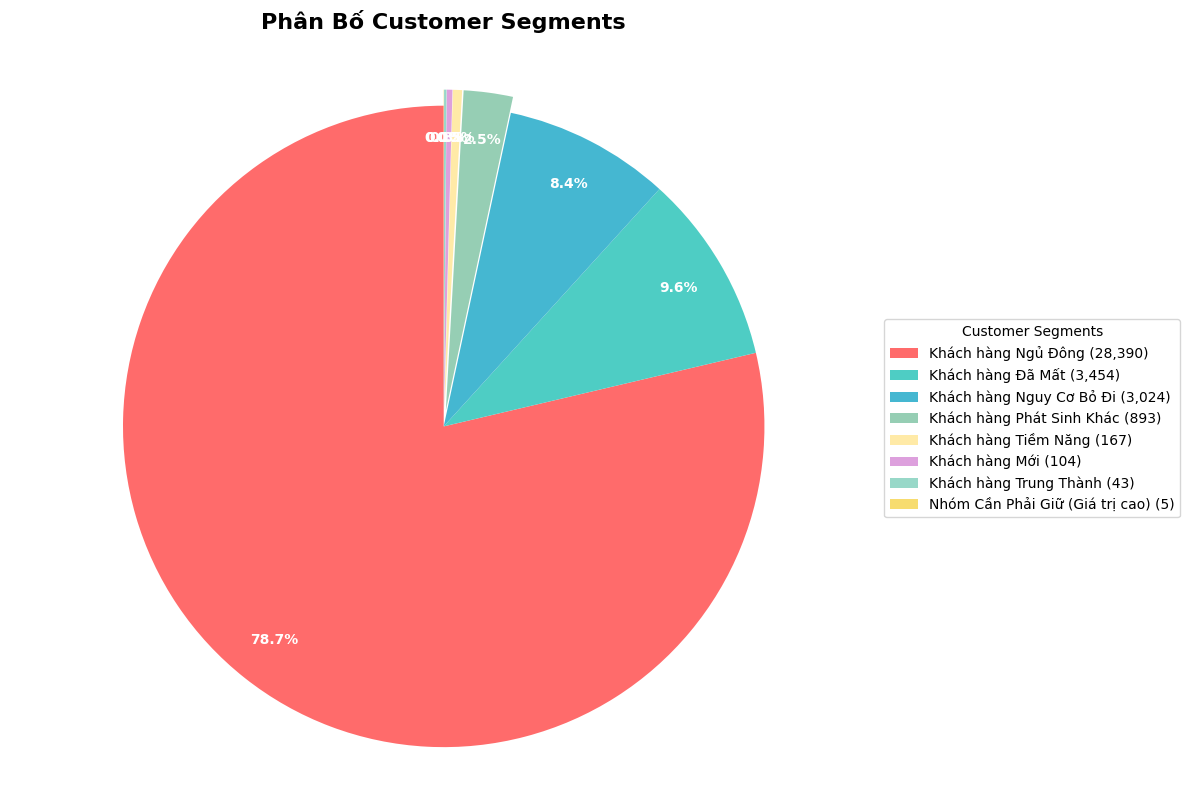

In [78]:
# Tạo biểu đồ tròn với layout tối ưu để tránh chồng chéo
plt.figure(figsize=(12, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F']

# Tạo explode cho các segment nhỏ để tách biệt
explode = [0.05 if count < 1000 else 0 for count in segment_counts.values]

# Sử dụng segment_counts đã tính sẵn
wedges, texts, autotexts = plt.pie(segment_counts.values, 
                                  labels=None,  # Bỏ labels để tránh chồng chéo
                                  autopct='%1.1f%%', 
                                  colors=colors, 
                                  startangle=90,
                                  explode=explode,
                                  pctdistance=0.85)

# Tùy chỉnh text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# Tạo legend bên ngoài biểu đồ để tránh chồng chéo
plt.legend(wedges, [f'{label} ({count:,})' for label, count in segment_counts.items()],
           title="Customer Segments",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1),
           fontsize=10)

plt.title('Phân Bố Customer Segments', 
          fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

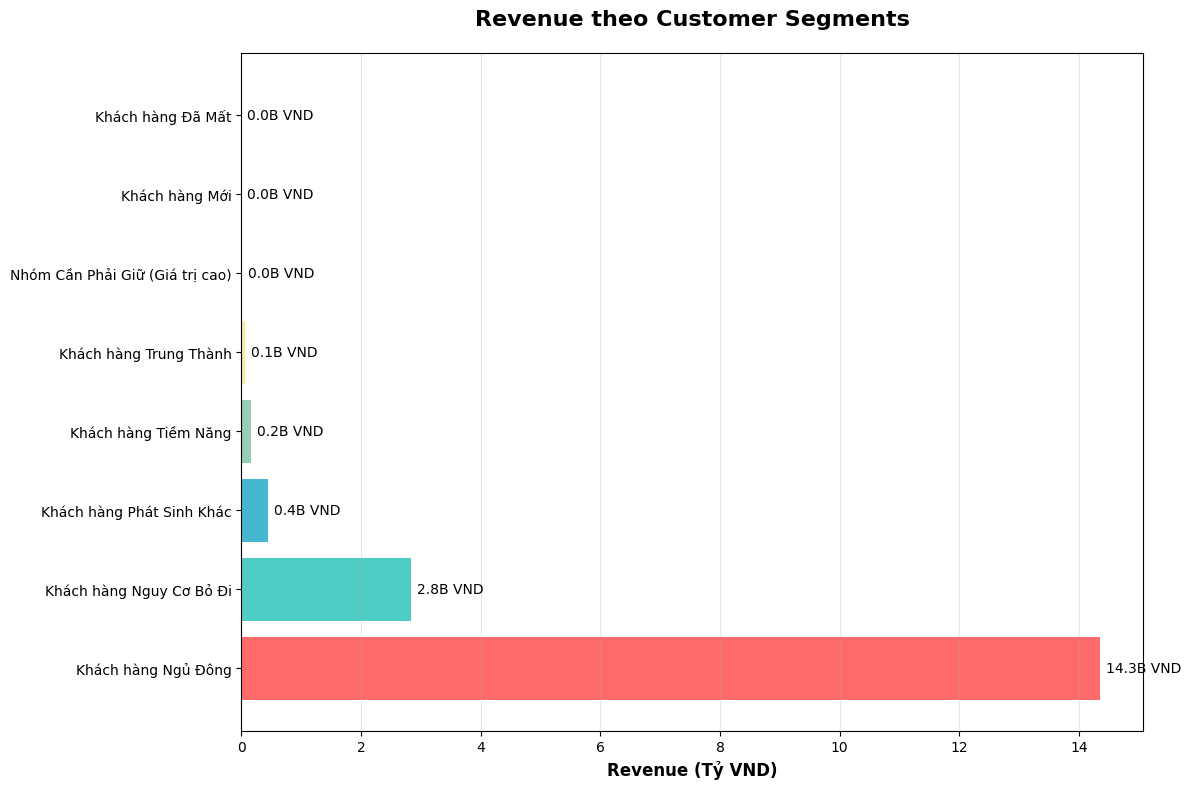

In [79]:
# Sử dụng dữ liệu thực tế từ segment_revenue
plt.figure(figsize=(12, 8))

# Sử dụng segment_revenue đã tính sẵn
segments = segment_revenue.index
revenues = segment_revenue.values

# Chuyển đổi sang tỷ VND
revenues_billions = revenues / 1000000000

# Tạo horizontal bar chart
bars = plt.barh(segments, revenues_billions, color=colors)

# Thêm giá trị trên mỗi bar
for i, (bar, revenue) in enumerate(zip(bars, revenues_billions)):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{revenue:.1f}B VND', va='center')

plt.xlabel('Revenue (Tỷ VND)', fontsize=12, fontweight='bold')
plt.title('Revenue theo Customer Segments', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

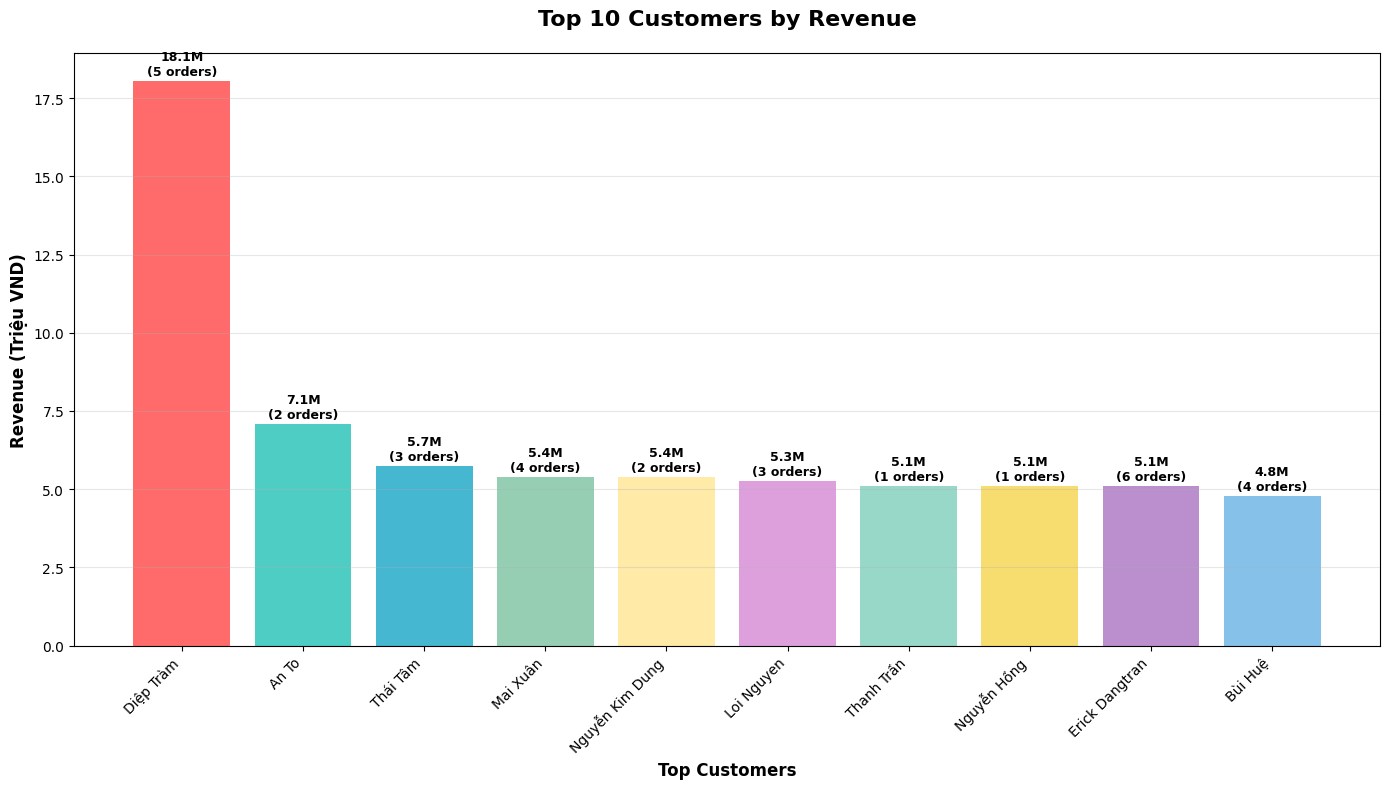

In [80]:
# Sử dụng dữ liệu thực tế từ top_customers
plt.figure(figsize=(14, 8))

# Lấy dữ liệu từ top_customers
top_customers_data = rfm_table.nlargest(10, 'monetary')
names = top_customers_data['name'].tolist()
revenues = top_customers_data['monetary'].tolist()
orders = top_customers_data['frequency'].tolist()

# Chuyển đổi sang triệu VND
revenues_millions = [r/1000000 for r in revenues]

bars = plt.bar(range(len(names)), revenues_millions, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7',
                      '#DDA0DD', '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9'])

# Thêm giá trị trên mỗi bar
for i, (bar, revenue, order) in enumerate(zip(bars, revenues_millions, orders)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{revenue:.1f}M\n({order} orders)', ha='center', va='bottom', 
             fontweight='bold', fontsize=9)

plt.xlabel('Top Customers', fontsize=12, fontweight='bold')
plt.ylabel('Revenue (Triệu VND)', fontsize=12, fontweight='bold')
plt.title('Top 10 Customers by Revenue', fontsize=16, fontweight='bold', pad=20)
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1500x600 with 0 Axes>

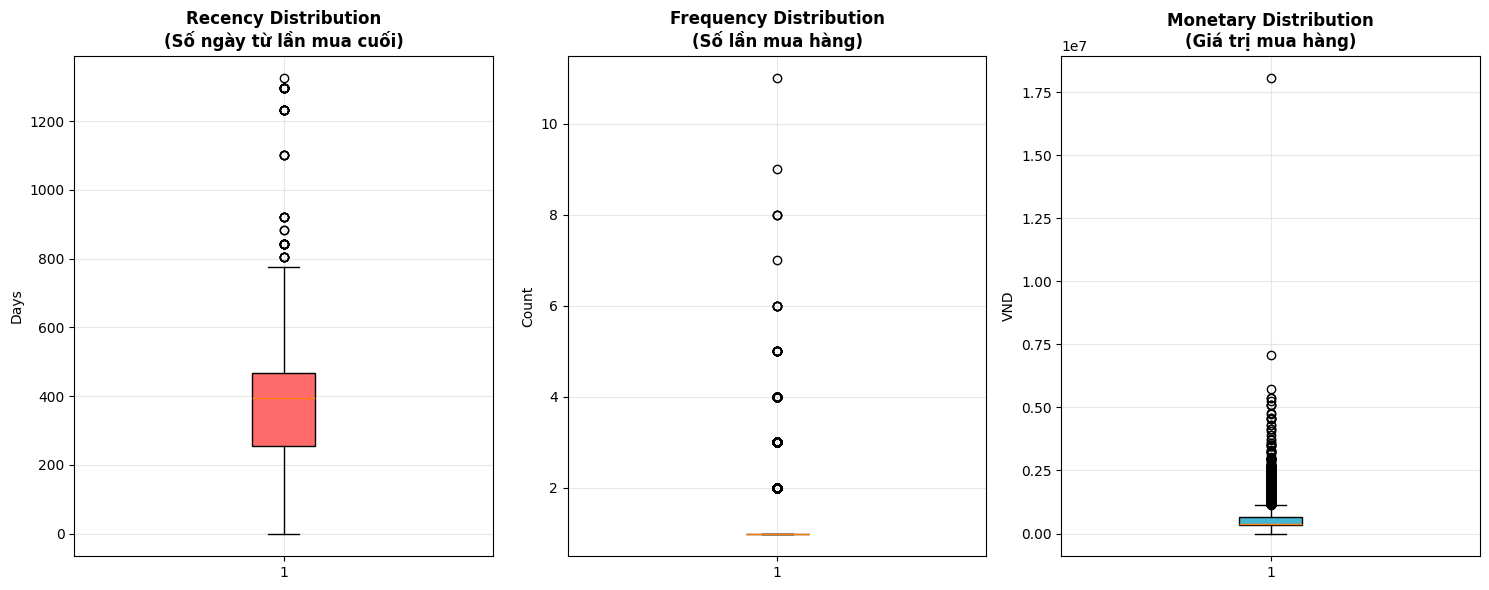

In [81]:
# Sử dụng dữ liệu thực tế từ rfm_table
plt.figure(figsize=(15, 6))

# Tạo subplot cho từng metric
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Recency
axes[0].boxplot(rfm_table['recency'], patch_artist=True, boxprops=dict(facecolor='#FF6B6B'))
axes[0].set_title('Recency Distribution\n(Số ngày từ lần mua cuối)', fontweight='bold')
axes[0].set_ylabel('Days')
axes[0].grid(True, alpha=0.3)

# Frequency  
axes[1].boxplot(rfm_table['frequency'], patch_artist=True, boxprops=dict(facecolor='#4ECDC4'))
axes[1].set_title('Frequency Distribution\n(Số lần mua hàng)', fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3)

# Monetary
axes[2].boxplot(rfm_table['monetary'], patch_artist=True, boxprops=dict(facecolor='#45B7D1'))
axes[2].set_title('Monetary Distribution\n(Giá trị mua hàng)', fontweight='bold')
axes[2].set_ylabel('VND')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### C. Customer Lifetime Value (CLV)

### D. Behavioral Analysis

#### 1. Mẫu Mua Hàng (Purchase Patterns)

In [85]:
## 1. Mẫu Mua Hàng (Purchase Patterns)

# Chuẩn bị dữ liệu cho phân tích mẫu mua hàng
def prepare_purchase_patterns_data():
    
    # Merge orders với date information
    orders_with_date = df_orders.merge(df_date, on='date_id', how='inner')
    
    # Thêm các cột thời gian
    orders_with_date['day_of_week'] = orders_with_date['inserted_at'].dt.day_name()
    orders_with_date['day_of_week_num'] = orders_with_date['inserted_at'].dt.dayofweek
    orders_with_date['hour'] = orders_with_date['inserted_at'].dt.hour
    
    # Thêm thông tin mùa
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Đông'
        elif month in [3, 4, 5]:
            return 'Xuân'
        elif month in [6, 7, 8]:
            return 'Hè'
        else:
            return 'Thu'
    
    orders_with_date['season'] = orders_with_date['month'].apply(get_season)
    
    return orders_with_date

# Chuẩn bị dữ liệu
orders_patterns = prepare_purchase_patterns_data()